In [77]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from typing import List, Tuple
import string
from os import walk
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,matthews_corrcoef,roc_curve, auc
import seaborn as sns

In [78]:
def getCmaps(file,path):
    gt=np.load(path+'gt/'+file)
    esm=np.load(path+'esm_cmaps/'+file)
    alpha=np.load(path+'alpha_fold_cmaps/'+file)
    pcons=np.load(path+'pconsc4/'+file)
    pcons=pcons >= 0.5
    pcons=np.multiply(pcons,1)
    #rand=np.load(path+'esm/'+file)
    rand=np.load(path+'rand_cmaps/'+file)
    return gt,alpha,esm,pcons,rand

In [4]:
filenames = next(walk('/Users/rohan/Desktop/contact_map_analysis/kiba_cmaps/gt/'), (None, None, []))[2]

In [7]:
path='/Users/rohan/Desktop/contact_map_analysis/kiba_cmaps/'
for file in filenames:
        # Load the contact maps
        print(file)
        gt,alpha,esm,pcons,rand=getCmaps(file,path)
        print(gt.shape,alpha.shape,esm.shape,pcons.shape,rand.shape)

P11802.npy
(285, 285) (303, 303) (303, 303) (303, 303) (303, 303)
P19784.npy
(350, 350) (350, 350) (350, 350) (350, 350) (350, 350)
P24941.npy
(298, 298) (298, 298) (298, 298) (298, 298) (298, 298)
P50750.npy
(372, 372) (372, 372) (372, 372) (372, 372) (372, 372)
Q16539.npy
(360, 360) (360, 360) (360, 360) (360, 360) (360, 360)
P67870.npy
(193, 193) (215, 215) (215, 215) (215, 215) (215, 215)
P06493.npy
(297, 297) (297, 297) (297, 297) (297, 297) (297, 297)
P17612.npy
(345, 345) (351, 351) (351, 351) (351, 351) (351, 351)
P68400.npy
(390, 390) (391, 391) (391, 391) (391, 391) (391, 391)
P28482.npy
(356, 356) (360, 360) (360, 360) (360, 360) (360, 360)
Q00535.npy
(292, 292) (292, 292) (292, 292) (292, 292) (292, 292)
P27361.npy
(366, 366) (379, 379) (379, 379) (379, 379) (379, 379)
O43741.npy
(272, 272) (272, 272) (272, 272) (272, 272) (272, 272)


In [8]:
# With no missing residues
files= [
 'P19784.npy',
 'P24941.npy',
 'P50750.npy',
 'Q16539.npy',
 'P06493.npy',
 'Q00535.npy',
 'O43741.npy']

In [6]:
results_path = "/Users/rohan/Desktop/contact_map_analysis/kiba_cmaps"

In [12]:
def calculate_metrics(gt, contact_map):
    L=gt.shape[0]
    gt = gt.flatten()
    contact_map = contact_map.flatten()
    mcc = matthews_corrcoef(gt, contact_map)
    f1=f1_score(gt, contact_map)
    precision = precision_score(gt, contact_map, zero_division=0)
    
    # calculate precision for short, medium, and long-range contacts
    contact_type = np.zeros(L * L)
    for i in range(L):
        for j in range(i+6, min(i+11, L)):
            contact_type[i*L+j] = 1  # short-range contact
            contact_type[j*L+i] = 1
        for j in range(i+12, min(i+23, L)):
            contact_type[i*L+j] = 2  # medium-range contact
            contact_type[j*L+i] = 2
        for j in range(i+24, L):
            contact_type[i*L+j] = 3  # long-range contact
            contact_type[j*L+i] = 3
            
    precision_short_range = precision_score(gt[contact_type==1], contact_map[contact_type==1], zero_division=0)
    precision_medium_range = precision_score(gt[contact_type==2], contact_map[contact_type==2], zero_division=0)
    precision_long_range = precision_score(gt[contact_type==3], contact_map[contact_type==3], zero_division=0)
    
    return mcc, f1, precision, precision_short_range, precision_medium_range, precision_long_range


In [13]:
for method in ["alpha_fold_cmaps", "esm_cmaps", "pconsc4", "rand_cmaps"]:
    method_true_contacts = []
    method_mcc = []
    method_f1 = []
    method_precision = []
    method_precision_short_range = []
    method_precision_medium_range = []
    method_precision_long_range = []
    for file in files:
        # Load the contact maps
        gt = np.load(results_path + "/gt/" + file)
        contact_map = np.load(results_path + "/" + method + "/" + file)
        if method=="pconsc4":
            contact_map =contact_map  >= 0.5
            contact_map =np.multiply(contact_map,1)
        min_shape = min(gt.shape, contact_map.shape)
        gt = gt[:min_shape[0], :min_shape[1]]
        contact_map= contact_map[:min_shape[0], :min_shape[1]]

        # Compare the contact maps
        true_contacts = np.sum(np.logical_and(contact_map == 1, gt == 1)) / np.sum(gt == 1)
        mcc,f1, precision, precision_short_range, precision_medium_range, precision_long_range = calculate_metrics(gt,contact_map)

        method_true_contacts.append(true_contacts)
        method_mcc.append(mcc)
        method_f1.append(f1)
        method_precision.append(precision)
        method_precision_short_range.append(precision_short_range)
        method_precision_medium_range.append(precision_medium_range)
        method_precision_long_range.append(precision_long_range)

    # Calculate the average percentage of true contacts and false contacts across all examples for the current method
    avg_true_contacts = np.mean(method_true_contacts)
    avg_mcc = np.mean(method_mcc)
    avg_f1=np.mean(method_f1)
    avg_precision = np.mean(method_precision)
    avg_precision_short_range = np.mean(method_precision_short_range)
    avg_precision_medium_range = np.mean(method_precision_medium_range)
    avg_precision_long_range = np.mean(method_precision_long_range)

    # Print the results
    print("Method:", method)
    print("Average mcc compared to groundtruth:", avg_mcc) 
    print("Average f1 compared to groundtruth:", avg_f1)  
    print("Average precision compared to groundtruth:",avg_precision)
    print("Average precision_short_range  compared to groundtruth:",avg_precision_short_range)
    print("Average precision_medium_range compared to groundtruth:", avg_precision_medium_range)
    print("Average precision_long_range compared to groundtruth:", avg_precision_long_range)


Method: alpha_fold_cmaps
Average mcc compared to groundtruth: 0.16957204874640203
Average f1 compared to groundtruth: 0.17480790706268604
Average precision compared to groundtruth: 0.17480790706268604
Average precision_short_range  compared to groundtruth: 0.06788035313380937
Average precision_medium_range compared to groundtruth: 0.0585458857872651
Average precision_long_range compared to groundtruth: 0.03849761496607007
Method: esm_cmaps
Average mcc compared to groundtruth: 0.042573500075522484
Average f1 compared to groundtruth: 0.04848364777221727
Average precision compared to groundtruth: 0.03832089259471668
Average precision_short_range  compared to groundtruth: 0.03646190410776579
Average precision_medium_range compared to groundtruth: 0.035303557762696204
Average precision_long_range compared to groundtruth: 0.022580879361191804
Method: pconsc4
Average mcc compared to groundtruth: 0.22796002784766406
Average f1 compared to groundtruth: 0.19457459262326657
Average precision comp

In [73]:
sns.set(font_scale =2,style="white")

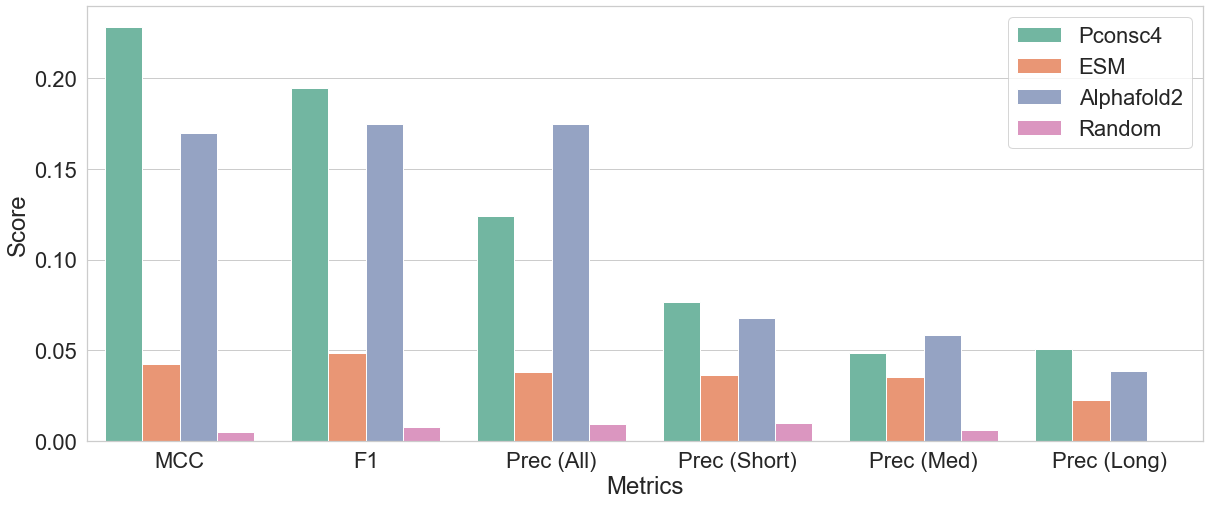

In [76]:
fig = plt.figure(figsize=(20, 8))
# plot bar plot
sns.set(font_scale=2, style="whitegrid")
ax=sns.barplot(x='metric', y='score', hue='method', data=df_melted, palette='Set2', ci='sd')

# set legend
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# set axis labels and title
plt.xlabel('Metrics')
plt.ylabel('Score')

# show plot
plt.show()

final_result_path='/Users/rohan/Desktop/contact_map_analysis/kiba_cmaps/'+'Fig3BA.pdf'
final_result_path1='/Users/rohan/Desktop/contact_map_analysis/kiba_cmaps/'+'Fig3BA.png'

fig.savefig(final_result_path, dpi=300, bbox_inches='tight')
fig.savefig(final_result_path1, dpi=300, bbox_inches='tight')
